# PhageFilter Benchmarking Notebook

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Helper Functions

In [74]:
def get_read_name_counts(fasta_path):
    """
    works for all 3
    return dict
    """
    parsed_file = {}
    with open(fasta_path) as fasta:
        line = fasta.readline()
        while line:
            if line[0] == ">":
                name = line.strip(">").split(" ")[0].split("-")[0]
                if name in parsed_file:
                    parsed_file[name] += 1
                else:
                    parsed_file[name] = 1
            line = fasta.readline() 
    return parsed_file

def parse_directory(genome_path):
    """
    This parses a directory of fasta/fastq files.
    """
    parsed_genomes = {}
    for file in os.listdir(genome_path):
        parsed_genomes.update(get_read_name_counts(genome_path+file))
    return parsed_genomes

def benchmark(parsed_reads, parsed_filtered_reads, parsed_genomes):
    """
    Method to calculate true/false positives and true/false negatives
    """
    results = {"TP":0, "FP":0, "FN":0, "TN":0}
    for filtered_read, count in parsed_filtered_reads.items():
        if filtered_read in parsed_genomes.keys():
            results["TP"] += count
            results["FN"] += parsed_reads[filtered_read] - count 
        else:
            results["FP"] += count
            results["TN"] += parsed_reads[filtered_read] - count
    return results

def get_read_file(filtered_file):
    """
    Returns the read files based on the benchmarking file name
    """
    return "_".join(filtered_file.split("_")[:4]) + ".fa"

def get_metrics(results_dict):
    """
    Method to obtain recall, precision and F1 given
    true/false positives and true/false negatives
    """
    metrics = {}
    metrics["precision"] = results_dict["TP"] / (results_dict["TP"] + results_dict["FP"])
    metrics["recall"] = results_dict["TP"] / (results_dict["TP"] + results_dict["FN"])
    metrics["f1"] = 2 * (metrics["precision"]*metrics["recall"]) / (metrics["precision"]+metrics["recall"])
    return metrics 

def benchmark_directories(filtered_reads_dir, genomes_dir):
    """
    Full benchmarking method
    """
    full_results = {}
    parsed_genomes = parse_directory(genomes_dir)
    for filtered_reads_path in os.listdir(filtered_reads_dir):
        reads_path = get_read_file(filtered_reads_path)
        # parse reads
        parsed_reads = get_read_name_counts("b1/"+reads_path)
        parsed_filtered_reads = get_read_name_counts(filtered_reads_dir+filtered_reads_path)
        # get basic results
        results = benchmark(parsed_reads, parsed_filtered_reads, parsed_genomes)
        results.update(get_metrics(results))
        full_results[filtered_reads_path] = results
    return full_results

# Analysis

In [92]:
filtered_reads_dir = "b1_out2/"
genomes_dir = "../genomes/viral_genome_dir/"
final_results = benchmark_directories(filtered_reads_dir, genomes_dir)

# Plotting

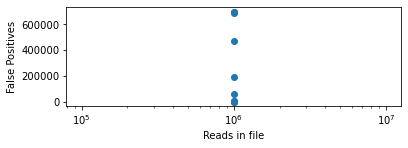

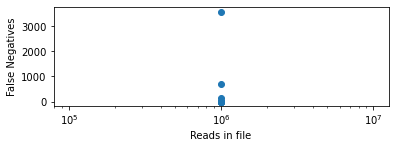

In [93]:
# number of false positives/negatives over read count size
FN_arr = []
FP_arr = []
names = []
for file, result in final_results.items():
    FP_arr.append(result["FP"])
    FN_arr.append(result["FN"])
    names.append(int(file.split("_")[2]))
    
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_xscale('log')
ax.scatter(names, FP_arr)
ax.set_ylabel("False Positives")
ax.set_xlabel("Reads in file")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_xscale('log')
ax.scatter(names, FN_arr)
ax.set_ylabel("False Negatives")
ax.set_xlabel("Reads in file")
plt.show()

Text(0, 0.5, 'F1 Score')

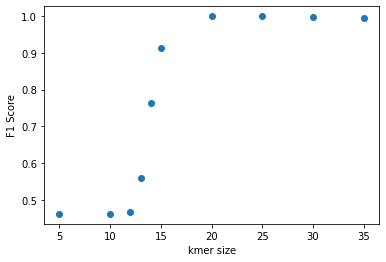

In [94]:
# number of false positives/negatives over kmer size
FN_arr = []
FP_arr = []
names = []
for file, result in final_results.items():
    FP_arr.append(result["f1"])
    names.append(int(file.strip("fa").split("_")[-1].strip("k").strip(".")))
    
plt.scatter(names, FP_arr)
plt.xlabel("kmer size")
plt.ylabel("F1 Score")